Processing dataset ...


  0%|          | 0/234 [00:00<?, ?it/s]

... done. Total 60000 data entries.



  0%|          | 0/100 [00:09<?, ?it/s]


KeyboardInterrupt: 

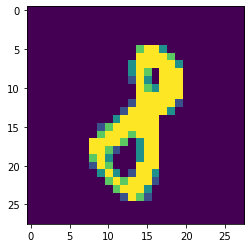

In [158]:
import struct
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image

from hw5_utils import BASE_URL, download, GANDataset

class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.size())
        return x

class DNet(nn.Module):
    """This is discriminator network."""

    def __init__(self):
        super(DNet, self).__init__()
        
        # TODO: implement layers here
        self.model = nn.Sequential(
            nn.Conv2d(1,2,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(2,4,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(4,8,3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(5*5*8,1),
        )
        

        self._weight_init()

    def _weight_init(self):
        # TODO: implement weight initialization here
        for child in self.model.children():
            if type(child) == (nn.Conv2d) or type(child)==nn.Linear:
                nn.init.kaiming_uniform_(child.weight)
                nn.init.zeros_(child.bias)

    def forward(self, x):
        # TODO: complete forward function
        x = self.model(x)
        return x


class GNet(nn.Module):
    """This is generator network."""

    def __init__(self, zdim):
        """
        Parameters
        ----------
            zdim: dimension for latent variable.
        """
        super(GNet, self).__init__()

        # TODO: implement layers here
        self.model1 = nn.Sequential(
            nn.Linear(zdim,1568),
            nn.LeakyReLU(0.2)
            )
        self.model2 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32,16,3,padding=1),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16,8,3,padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(8,1,3,padding=1),
            nn.Sigmoid()
            )
        
        self._weight_init()

    def _weight_init(self):
        # TODO: implement weight initialization here
        for child in self.model1.children():
            if type(child) == (nn.Conv2d) or type(child)==nn.Linear:
                nn.init.kaiming_uniform_(child.weight)
                nn.init.zeros_(child.bias)
        for child in self.model2.children():
            if type(child) == (nn.Conv2d) or type(child)==nn.Linear:
                nn.init.kaiming_uniform_(child.weight)
                nn.init.zeros_(child.bias)
        
        

    def forward(self, z):
        """
        Parameters
        ----------
            z: latent variables used to generate images.
        """
        # TODO: complete forward function
        z_temp = self.model1(z)
        z = z_temp.view(-1,32,7,7)
        z = self.model2(z)
        return z

class GAN:
    def __init__(self, zdim=64):
        """
        Parameters
        ----------
            zdim: dimension for latent variable.
        """
        torch.manual_seed(2)
        self._dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self._zdim = zdim
        self.disc = DNet().to(self._dev)
        self.gen = GNet(self._zdim).to(self._dev)

    def _get_loss_d(self, batch_size, batch_data, z):
        """This function computes loss for discriminator.

        Parameters
        ----------
            batch_size: #data per batch.
            batch_data: data from dataset.
            z: random latent variable.
        """
        # TODO: implement discriminator's loss function
        criterion = nn.BCEWithLogitsLoss()
        loss_real = criterion(self.disc(batch_data),torch.ones(batch_size,1))
        loss_fake = criterion(self.disc(self.gen(z)),torch.zeros(batch_size,1))
        
        loss_d = (loss_real + loss_fake)/2
        return loss_d

    def _get_loss_g(self, batch_size, z):
        """This function computes loss for generator.

        Parameters
        ----------
            batch_size: #data per batch.
            z: random latent variable.
        """
        # TODO: implement generator's loss function
        criterion = nn.BCEWithLogitsLoss()
        loss_g = criterion(self.disc(self.gen(z)),torch.ones(batch_size,1))
        return loss_g

    def train(self, iter_d=1, iter_g=1, n_epochs=100, batch_size=256, lr=0.0002):

        # first download
        f_name = "train-images-idx3-ubyte.gz"
        download(BASE_URL + f_name, f_name)

        print("Processing dataset ...")
        train_data = GANDataset(
            f"./data/{f_name}",
            self._dev,
            transform=transforms.Compose([transforms.Normalize((0.0,), (255.0,))]),
        )
        print(f"... done. Total {len(train_data)} data entries.")

        train_loader = DataLoader(
            train_data,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            drop_last=True,
        )

        dopt = optim.Adam(self.disc.parameters(), lr=lr, weight_decay=0.0)
        dopt.zero_grad()
        gopt = optim.Adam(self.gen.parameters(), lr=lr, weight_decay=0.0)
        gopt.zero_grad()

        for epoch in tqdm(range(n_epochs)):
            for batch_idx, data in tqdm(
                enumerate(train_loader), total=len(train_loader)
            ):

                z = 2 * torch.rand(data.size()[0], self._zdim, device=self._dev) - 1

                if batch_idx == 0 and epoch == 0:
                    plt.imshow(data[0, 0, :, :].detach().cpu().numpy())
                    plt.savefig("goal.pdf")

                if batch_idx == 0 and epoch % 10 == 0:
                    with torch.no_grad():
                        tmpimg = self.gen(z)[0:64, :, :, :].detach().cpu()
                    save_image(
                        tmpimg, "test_{0}.png".format(epoch), nrow=8, normalize=True
                    )

                dopt.zero_grad()
                for k in range(iter_d):
                    loss_d = self._get_loss_d(batch_size, data, z)
                    loss_d.backward()
                    dopt.step()
                    dopt.zero_grad()

                gopt.zero_grad()
                for k in range(iter_g):
                    loss_g = self._get_loss_g(batch_size, z)
                    loss_g.backward()
                    gopt.step()
                    gopt.zero_grad()

            print(f"E: {epoch}; DLoss: {loss_d.item()}; GLoss: {loss_g.item()}")


if __name__ == "__main__":
    gan = GAN()
    gan.train()


In [151]:
class DNet(nn.Module):
    """This is discriminator network."""

    def __init__(self):
        super(DNet, self).__init__()
        
        # TODO: implement layers here
        self.model = nn.Sequential(
            nn.Conv2d(1,2,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(2,4,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(4,8,3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(5*5*8,1),
        )
        

        self._weight_init()

    def _weight_init(self):
        # TODO: implement weight initialization here
        for child in self.model.children():
            #print(child.parameters())
            #print(child.__class__.__name__)
            #print(type(child))
            if type(child) == (nn.Conv2d) or type(child)==nn.Linear:
                print(child)
                nn.init.kaiming_uniform_(child.weight)
                nn.init.zeros_(child.bias)
            
    def forward(self, x):
        # TODO: complete forward function
        x = self.model(x)
        return x

In [152]:
net = DNet()


Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
Linear(in_features=200, out_features=1, bias=True)


In [153]:
net.model[-1]

Linear(in_features=200, out_features=1, bias=True)

In [155]:
net.model[0].bias

Parameter containing:
tensor([0., 0.], requires_grad=True)

In [53]:
x = torch.randn(256,3,3,2)

In [54]:
a = nn.Flatten()


In [56]:
a(x).size()

torch.Size([256, 18])

In [4]:
from torch.autograd import Variable
import torch

Processing dataset ...


  0%|          | 0/234 [00:00<?, ?it/s]

... done. Total 60000 data entries.



  0%|          | 0/100 [00:03<?, ?it/s]


KeyboardInterrupt: 

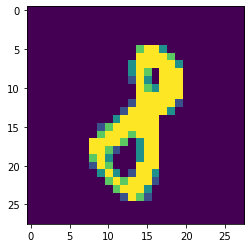

In [79]:
import struct

import matplotlib

import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm



import torch

import torch.optim as optim

import torch.nn as nn

import torch.nn.functional as F

from torch.utils.data import DataLoader

from torchvision import transforms

from torchvision.utils import save_image



from hw5_utils import BASE_URL, download, GANDataset





class DNet(nn.Module):

    """This is discriminator network."""



    def __init__(self):

        super(DNet, self).__init__()

        

        # TODO: implement layers here

        self.f = nn.Sequential(

            nn.Conv2d(1, 2, kernel_size=3, stride=1, padding=1, bias=True),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(2, 4, kernel_size=3, stride=1, padding=1, bias=True),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=0, bias=True),

            nn.ReLU(),

            nn.Flatten(),

            nn.Linear(8*5*5, 1, bias=True)

        )



        self._weight_init()



    def _weight_init(self):

        # TODO: implement weight initialization here

        for child in list(self.f.children()):

            if isinstance(child, nn.Conv2d) or isinstance(child, nn.Linear):

                nn.init.kaiming_uniform_(child.weight.data)

                nn.init.zeros_(child.bias.data)



    def forward(self, x):

        # TODO: complete forward function

        return self.f(x)





class GNet(nn.Module):

    """This is generator network."""



    def __init__(self, zdim):

        """

        Parameters

        ----------

            zdim: dimension for latent variable.

        """

        super(GNet, self).__init__()



        # TODO: implement layers here

        self.f1 = nn.Sequential(

            nn.Linear(zdim, 1568, bias=True),

            nn.LeakyReLU(0.2)

        )

        self.f2 = nn.Sequential(

            nn.Upsample(scale_factor=2),

            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1, bias=True),

            nn.LeakyReLU(0.2),

            nn.Upsample(scale_factor=2),

            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1, bias=True),

            nn.LeakyReLU(0.2),

            nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=1, bias=True),

            nn.Sigmoid()

        )



        self._weight_init()



    def _weight_init(self):

        # TODO: implement weight initialization here

        for child in list(self.f1.children()):

            if isinstance(child, nn.Conv2d) or isinstance(child, nn.Linear):

                nn.init.kaiming_uniform_(child.weight.data)

                nn.init.zeros_(child.bias.data)



        for child in list(self.f2.children()):

            if isinstance(child, nn.Conv2d) or isinstance(child, nn.Linear):

                nn.init.kaiming_uniform_(child.weight.data)

                nn.init.zeros_(child.bias.data)



    def forward(self, z):

        """

        Parameters

        ----------

            z: latent variables used to generate images.

        """

        # TODO: complete forward function

        hidden = self.f1(z)

        return self.f2(hidden.view(-1, 32, 7, 7))





class GAN:

    def __init__(self, zdim=64):

        """

        Parameters

        ----------

            zdim: dimension for latent variable.

        """

        torch.manual_seed(2)

        self._dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")



        self._zdim = zdim

        self.disc = DNet().to(self._dev)

        self.gen = GNet(self._zdim).to(self._dev)



    def _get_loss_d(self, batch_size, batch_data, z):

        """This function computes loss for discriminator.



        Parameters

        ----------

            batch_size: #data per batch.

            batch_data: data from dataset.

            z: random latent variable.

        """

        # TODO: implement discriminator's loss function

        # pos_weight = torch.ones([batch_size])



        criterion = torch.nn.BCEWithLogitsLoss()



        loss_real = criterion(self.disc(batch_data), torch.ones((batch_size, 1), device=self._dev))

        loss_fake = criterion(self.disc(self.gen(z)), torch.zeros((batch_size, 1), device=self._dev))



        loss_d = (loss_real + loss_fake) / 2

        return loss_d



    def _get_loss_g(self, batch_size, z):

        """This function computes loss for generator.



        Parameters

        ----------

            batch_size: #data per batch.

            z: random latent variable.

        """

        # TODO: implement generator's loss function

        criterion = torch.nn.BCEWithLogitsLoss()



        loss_g = criterion(self.disc(self.gen(z)), torch.ones((batch_size, 1), device=self._dev))

        return loss_g



    def train(self, iter_d=1, iter_g=1, n_epochs=100, batch_size=256, lr=0.0002):



        # first download

        f_name = "train-images-idx3-ubyte.gz"

        download(BASE_URL + f_name, f_name)



        print("Processing dataset ...")

        train_data = GANDataset(

            f"./data/{f_name}",

            self._dev,

            transform=transforms.Compose([transforms.Normalize((0.0,), (255.0,))]),

        )

        print(f"... done. Total {len(train_data)} data entries.")



        train_loader = DataLoader(

            train_data,

            batch_size=batch_size,

            shuffle=True,

            num_workers=0,

            drop_last=True,

        )



        dopt = optim.Adam(self.disc.parameters(), lr=lr, weight_decay=0.0)

        dopt.zero_grad()

        gopt = optim.Adam(self.gen.parameters(), lr=lr, weight_decay=0.0)

        gopt.zero_grad()



        for epoch in tqdm(range(n_epochs)):

            for batch_idx, data in tqdm(

                enumerate(train_loader), total=len(train_loader)

            ):



                z = 2 * torch.rand(data.size()[0], self._zdim, device=self._dev) - 1



                if batch_idx == 0 and epoch == 0:

                    plt.imshow(data[0, 0, :, :].detach().cpu().numpy())

                    plt.savefig("goal.pdf")



                if batch_idx == 0 and epoch % 10 == 0:

                    with torch.no_grad():

                        tmpimg = self.gen(z)[0:64, :, :, :].detach().cpu()

                    save_image(

                        tmpimg, "test_{0}.png".format(epoch), nrow=8, normalize=True

                    )



                dopt.zero_grad()

                for k in range(iter_d):

                    loss_d = self._get_loss_d(batch_size, data, z)

                    loss_d.backward()

                    dopt.step()

                    dopt.zero_grad()



                gopt.zero_grad()

                for k in range(iter_g):

                    loss_g = self._get_loss_g(batch_size, z)

                    loss_g.backward()

                    gopt.step()

                    gopt.zero_grad()



            print(f"E: {epoch}; DLoss: {loss_d.item()}; GLoss: {loss_g.item()}")





if __name__ == "__main__":

    gan = GAN()

    gan.train()



In [44]:
torch.flatten(x)

tensor([11,  4,  2,  1,  2,  3,  2,  5])

In [46]:
m = nn.Linear(20, 30)
input = torch.randn(128, 20)
output = m(input)
print(output.size())

torch.Size([128, 30])


In [156]:
class GNet(nn.Module):
    """This is generator network."""

    def __init__(self, zdim):
        """
        Parameters
        ----------
            zdim: dimension for latent variable.
        """
        super(GNet, self).__init__()

        # TODO: implement layers here
        self.fc1 = nn.Linear(zdim,1568)
        #Relu
        self.relu = nn.LeakyReLU(0.2)
        self.upsample1 = nn.Upsample(scale_factor =2)
        self.conv1 = nn.Conv2d(32,16,3,padding=1)
        ##Relu
        self.relu2 = nn.LeakyReLU(0.2)
        self.upsample2 = nn.Upsample(scale_factor = 2)
        self.conv2 = nn.Conv2d(16,8,3,padding = 1)
        self.relu3 = nn.LeakyReLU(0.2)
        self.conv3 = nn.Conv2d(8,1,3,padding = 1)
        self.sigmoid = nn.Sigmoid()
        self._weight_init()

    def _weight_init(self):
        # TODO: implement weight initialization here
        nn.init.kaiming_uniform_(self.conv1.weight)
        nn.init.kaiming_uniform_(self.conv2.weight)
        nn.init.kaiming_uniform_(self.conv3.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.conv1.bias)
        nn.init.zeros_(self.conv2.bias)
        nn.init.zeros_(self.conv3.bias)

    def forward(self, z):
        """
        Parameters
        ----------
            z: latent variables used to generate images.
        """
        # TODO: complete forward function
        z = self.fc1(z)
        z = self.relu(z)
        #z = F.leaky_relu(z,0.2)
        z = z.view(-1,32,7,7)
        z = self.upsample1(z)
        #z = F.leaky_relu(self.conv1(z),0.2)
        z = self.conv1(z)
        z = self.relu2(z)
        #z = self.relu2(self.conv1(z),0.2)
        z = self.upsample2(z)
        #z = F.leaky_relu(self.conv2(z),0.2)
        z = self.conv2(z)
        z = self.relu3(z)
        z = self.conv3(z)
        z = self.sigmoid(z)
        #z = F.sigmoid(self.conv3(z))
        #z = self.sigmoid(self.conv3(z))
        return z

In [158]:
g = GNet(10)
g

GNet(
  (fc1): Linear(in_features=10, out_features=1568, bias=True)
  (relu): LeakyReLU(negative_slope=0.2)
  (upsample1): Upsample(scale_factor=2.0, mode=nearest)
  (conv1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): LeakyReLU(negative_slope=0.2)
  (upsample2): Upsample(scale_factor=2.0, mode=nearest)
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): LeakyReLU(negative_slope=0.2)
  (conv3): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sigmoid): Sigmoid()
)

In [172]:
g.conv1.weight.size()

torch.Size([16, 32, 3, 3])

In [170]:
g2 = GNet2(10)
g2
g2.f2[1].weight.size()

Linear(in_features=10, out_features=1568, bias=True) Parameter containing:
tensor([[ 0.2704, -0.4921,  0.3480,  ..., -0.1466, -0.5017,  0.7449],
        [ 0.1114,  0.5307,  0.1091,  ..., -0.0559, -0.3466,  0.4842],
        [-0.3158,  0.1466,  0.0827,  ..., -0.0497,  0.1972, -0.0890],
        ...,
        [ 0.2438, -0.4411,  0.7375,  ...,  0.6158,  0.6671,  0.3513],
        [-0.4990,  0.4153,  0.5074,  ..., -0.6468, -0.4194,  0.0128],
        [ 0.1034, -0.2834,  0.6123,  ..., -0.6237, -0.7643, -0.1279]],
       requires_grad=True)
Linear(in_features=10, out_features=1568, bias=True) Parameter containing:
tensor([0., 0., 0.,  ..., 0., 0., 0.], requires_grad=True)


torch.Size([16, 32, 3, 3])

In [124]:
x = torch.randn(5,1,28,28)
x.shape

torch.Size([5, 1, 28, 28])

In [125]:
t1 = g.forward(x)
t1.size()
t1

tensor([[0.4360],
        [0.7328],
        [0.5797],
        [0.0066],
        [0.4851]], grad_fn=<AddmmBackward>)

In [126]:
t2 = g2.forward(x)
t2

tensor([[ 3.2797],
        [ 4.0545],
        [-0.0111],
        [ 5.7228],
        [ 2.4843]], grad_fn=<AddmmBackward>)

In [167]:
class GNet2(nn.Module):

    """This is generator network."""



    def __init__(self, zdim):

        """

        Parameters

        ----------

            zdim: dimension for latent variable.

        """

        super(GNet2, self).__init__()



        # TODO: implement layers here

        self.f1 = nn.Sequential(

            nn.Linear(zdim, 1568, bias=True),

            nn.LeakyReLU(0.2)

        )

        self.f2 = nn.Sequential(

            nn.Upsample(scale_factor=2),

            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1, bias=True),

            nn.LeakyReLU(0.2),

            nn.Upsample(scale_factor=2),

            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1, bias=True),

            nn.LeakyReLU(0.2),

            nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=1, bias=True),

            nn.Sigmoid()

        )



        self._weight_init()



    def _weight_init(self):

        # TODO: implement weight initialization here

        for child in list(self.f1.children()):

            if isinstance(child, nn.Conv2d) or isinstance(child, nn.Linear):

                nn.init.kaiming_uniform_(child.weight.data)

                nn.init.zeros_(child.bias.data)

                print(child,child.weight)
                print(child,child.bias)

        for child in list(self.f2.children()):

            if isinstance(child, nn.Conv2d) or isinstance(child, nn.Linear):

                nn.init.kaiming_uniform_(child.weight.data)

                nn.init.zeros_(child.bias.data)
               



    def forward(self, z):

        """

        Parameters

        ----------

            z: latent variables used to generate images.

        """

        # TODO: complete forward function

        hidden = self.f1(z)

        return self.f2(hidden.view(-1, 32, 7, 7))






In [108]:
class DNet2(nn.Module):

    """This is discriminator network."""



    def __init__(self):

        super(DNet2, self).__init__()

        

        # TODO: implement layers here

        self.f = nn.Sequential(

            nn.Conv2d(1, 2, kernel_size=3, stride=1, padding=1, bias=True),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(2, 4, kernel_size=3, stride=1, padding=1, bias=True),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=0, bias=True),

            nn.ReLU(),

            nn.Flatten(),

            nn.Linear(8*5*5, 1, bias=True)

        )



        self._weight_init()



    def _weight_init(self):

        # TODO: implement weight initialization here

        for child in list(self.f.children()):

            if isinstance(child, nn.Conv2d) or isinstance(child, nn.Linear):

                nn.init.kaiming_uniform_(child.weight.data)

                nn.init.zeros_(child.bias.data)



    def forward(self, x):

        # TODO: complete forward function

        return self.f(x)

